# Train SVM

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate, GridSearchCV
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.metrics import (
    confusion_matrix, classification_report, roc_auc_score,
    precision_recall_curve, auc, make_scorer, recall_score,
    precision_score, f1_score, RocCurveDisplay, PrecisionRecallDisplay
)
import matplotlib.pyplot as plt


# =============================================================================
# CONFIGURATION
# =============================================================================
# add book value per share
# Define your datasets
DATASETS = {
    'dataset_small': {
        'path': '/Users/adamsujecki/ST310-Predicting-Company-Bankruptcy/notebooks/features_NaN_removed_strong.csv',
        'feature_cols': ['revt', 'oibdp', 'ni', 'xint', 'dp', 'at', 'act', 'che', 'lt', 'lct', 'dlc', 'dltt', 'ceq', 'dv', 
        'cogs','ebit','re','rect','invt','oancf', 'capx', 'fincf', 'ivncf','prcc_f', 'ap', 
        'gross_margin', 'net_profit_margin', 'roa', 'roe', 'asset_turnover','cash_to_assets', 'fixed_asset_intensity', 'current_ratio', 'quick_ratio','total_debt', 'debt_to_assets', 'debt_to_equity', 'liabilities_to_assets','interest_coverage', 'long_term_debt_ratio', 'dividend_payout_ratio', 'dividend_yield', 'retention_ratio','revt_1_year_pct_change', 'at_1_year_pct_change', 'ni_1_year_pct_change','oibdp_1_year_pct_change', 'ceq_1_year_pct_change', 'total_debt_1_year_pct_change','revt_2_year_pct_change', 'at_2_year_pct_change', 'ni_2_year_pct_change','oibdp_2_year_pct_change', 'ceq_2_year_pct_change', 'total_debt_2_year_pct_change', 'revt_5_year_pct_change', 'at_5_year_pct_change', 'ni_5_year_pct_change','oibdp_5_year_pct_change', 'ceq_5_year_pct_change', 'total_debt_5_year_pct_change', 
        'capex_to_assets','investing_cash_flow_to_assets','days_sales_outstanding','days_inventory_outstanding','net_working_capital_to_assets','free_cash_flow_to_sales','financing_cash_flow_to_assets','market_capitalization', 'days_payables_outstanding','cash_conversion_cycle', 
        'capx_1_year_pct_change','market_capitalization_1_year_pct_change','free_cash_flow_to_sales_1_year_pct_change','financing_cash_flow_to_assets_1_year_pct_change', 
        'capx_2_year_pct_change','market_capitalization_2_year_pct_change','free_cash_flow_to_sales_2_year_pct_change','financing_cash_flow_to_assets_2_year_pct_change', 
        'capx_5_year_pct_change','market_capitalization_5_year_pct_change','free_cash_flow_to_sales_5_year_pct_change','financing_cash_flow_to_assets_5_year_pct_change', 
        'cash_conversion_cycle_1_year_pct_change','cash_conversion_cycle_2_year_pct_change','cash_conversion_cycle_5_year_pct_change' ],
        'log_cols': ['revt', 'oibdp', 'ni', 'xint', 'dp', 'at', 'act', 'che', 
        'lt', 'lct', 'dlc', 'dltt', 'ceq', 'dv', 
        'cogs','ebit','re','rect','invt','oancf', 
        'capx', 'fincf', 'ivncf','prcc_f', 'ap','total_debt','market_capitalization'] ,  # subset that needs loggin
    },
    'dataset_large': {
        'path': '/Users/adamsujecki/ST310-Predicting-Company-Bankruptcy/notebooks/features_NaN_removed_light.csv',
        'feature_cols': ['revt', 'oibdp', 'ni', 'xint', 'dp', 'at', 'act', 'che', 
        'lt', 'lct', 'dlc', 'dltt', 'ceq', 'dv', 
        'cogs','ebit','re','rect','invt','oancf', 'capx', 'fincf', 'ivncf','prcc_f', 'ap', 
        'gross_margin', 'net_profit_margin', 'roa', 'roe', 'asset_turnover','cash_to_assets', 'fixed_asset_intensity', 'current_ratio', 'quick_ratio','total_debt', 'debt_to_assets', 'debt_to_equity', 'liabilities_to_assets','interest_coverage', 'long_term_debt_ratio', 'dividend_payout_ratio', 'dividend_yield', 'retention_ratio','revt_1_year_pct_change', 'at_1_year_pct_change', 'ni_1_year_pct_change','oibdp_1_year_pct_change', 'ceq_1_year_pct_change', 'total_debt_1_year_pct_change','revt_2_year_pct_change', 'at_2_year_pct_change', 'ni_2_year_pct_change','oibdp_2_year_pct_change', 'ceq_2_year_pct_change', 'total_debt_2_year_pct_change', 'revt_5_year_pct_change', 'at_5_year_pct_change', 'ni_5_year_pct_change','oibdp_5_year_pct_change', 'ceq_5_year_pct_change', 'total_debt_5_year_pct_change', 
        'capex_to_assets','investing_cash_flow_to_assets','days_sales_outstanding','days_inventory_outstanding','net_working_capital_to_assets','free_cash_flow_to_sales','financing_cash_flow_to_assets','market_capitalization', 'days_payables_outstanding','cash_conversion_cycle','market_capitalization_1_year_pct_change', 
        'market_capitalization_2_year_pct_change'] ,
        'log_cols': ['revt', 'oibdp', 'ni', 'xint', 'dp', 'at', 'act', 'che', 
        'lt', 'lct', 'dlc', 'dltt', 'ceq', 'dv', 
        'cogs','ebit','re','rect','invt','oancf', 
        'capx', 'fincf', 'ivncf','prcc_f', 'ap','total_debt','market_capitalization'] ,  # subset that needs loggin
    },
}

OUTCOME_COLS = ['default_next_1y','default_next_2y','default_ever_future']  # replace with actual

TEST_SIZE = 0.2
RANDOM_STATE = 42
CV_FOLDS = 5


# =============================================================================
# PREPROCESSING FUNCTIONS
# =============================================================================

def signed_log1p(x):
    """
    Signed log transform that handles negative, zero, and positive values.
    Returns: sign(x) * log(1 + |x|)
    """
    return np.sign(x) * np.log1p(np.abs(x))


def create_preprocessor(feature_cols, log_cols):
    """
    Creates a column transformer that:
    1. Applies signed log transform to specified columns, then standardizes
    2. Standardizes remaining columns directly
    """
    non_log_cols = [c for c in feature_cols if c not in log_cols]
    
    transformers = []
    
    if log_cols:
        transformers.append((
            'log_features',
            Pipeline([
                ('log', FunctionTransformer(signed_log1p, validate=True)),
                ('scale', StandardScaler())
            ]),
            log_cols
        ))
    
    if non_log_cols:
        transformers.append((
            'standard_features',
            StandardScaler(),
            non_log_cols
        ))
    
    return ColumnTransformer(transformers, remainder='drop')


# =============================================================================
# MODEL PIPELINE
# =============================================================================

def create_svm_pipeline(preprocessor, kernel='linear'):
    """
    Creates full pipeline: preprocessing -> SVM
    """
    return Pipeline([
        ('preprocessor', preprocessor),
        ('svm', SVC(
            kernel=kernel,
            class_weight='balanced',
            probability=True,
            random_state=RANDOM_STATE
        ))
    ])


# =============================================================================
# EVALUATION FUNCTIONS
# =============================================================================

def evaluate_model(pipeline, X_train, X_test, y_train, y_test, threshold=0.5):
    """
    Comprehensive evaluation with adjustable threshold.
    """
    # Fit on training data
    pipeline.fit(X_train, y_train)
    
    # Get probabilities for threshold adjustment
    y_prob = pipeline.predict_proba(X_test)[:, 1]
    
    # Apply custom threshold
    y_pred = (y_prob >= threshold).astype(int)
    
    # Metrics
    results = {
        'confusion_matrix': confusion_matrix(y_test, y_pred),
        'classification_report': classification_report(y_test, y_pred, output_dict=True),
        'roc_auc': roc_auc_score(y_test, y_prob),
        'y_prob': y_prob,
        'y_pred': y_pred,
        'y_test': y_test,
    }
    
    # Precision-Recall AUC
    precision_vals, recall_vals, _ = precision_recall_curve(y_test, y_prob)
    results['pr_auc'] = auc(recall_vals, precision_vals)
    
    return results


def print_evaluation(results, dataset_name, outcome_col, kernel, threshold):
    """
    Prints formatted evaluation results.
    """
    print("\n" + "=" * 70)
    print(f"DATASET: {dataset_name} | OUTCOME: {outcome_col} | KERNEL: {kernel} | THRESHOLD: {threshold}")
    print("=" * 70)
    
    cm = results['confusion_matrix']
    print(f"\nConfusion Matrix:")
    print(f"                 Predicted 0    Predicted 1")
    print(f"  Actual 0       {cm[0,0]:>10,}    {cm[0,1]:>10,}")
    print(f"  Actual 1       {cm[1,0]:>10,}    {cm[1,1]:>10,}")
    
    report = results['classification_report']
    print(f"\nClass 1 (Default) Metrics:")
    print(f"  Precision: {report['1']['precision']:.3f}")
    print(f"  Recall:    {report['1']['recall']:.3f}")
    print(f"  F1-Score:  {report['1']['f1-score']:.3f}")
    
    print(f"\nOverall Metrics:")
    print(f"  Accuracy:  {report['accuracy']:.3f}")
    print(f"  ROC-AUC:   {results['roc_auc']:.3f}")
    print(f"  PR-AUC:    {results['pr_auc']:.3f}")


def plot_curves(results, dataset_name, outcome_col):
    """
    Plots ROC and Precision-Recall curves.
    """
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    # ROC Curve
    RocCurveDisplay.from_predictions(
        results['y_test'], results['y_prob'], ax=axes[0]
    )
    axes[0].set_title(f'ROC Curve\n{dataset_name} - {outcome_col}')
    axes[0].plot([0, 1], [0, 1], 'k--', label='Random')
    
    # Precision-Recall Curve
    PrecisionRecallDisplay.from_predictions(
        results['y_test'], results['y_prob'], ax=axes[1]
    )
    axes[1].set_title(f'Precision-Recall Curve\n{dataset_name} - {outcome_col}')
    
    plt.tight_layout()
    plt.show()

'''
def find_optimal_threshold(pipeline, X_train, y_train, optimize_for='f1'):
    """
    Uses cross-validation to find optimal threshold.
    """
    cv = StratifiedKFold(n_splits=CV_FOLDS, shuffle=True, random_state=RANDOM_STATE)
    
    all_y_true = []
    all_y_prob = []
    
    for train_idx, val_idx in cv.split(X_train, y_train):
        X_t, X_v = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_t, y_v = y_train.iloc[train_idx], y_train.iloc[val_idx]
        
        pipeline.fit(X_t, y_t)
        y_prob = pipeline.predict_proba(X_v)[:, 1]
        
        all_y_true.extend(y_v)
        all_y_prob.extend(y_prob)
    
    all_y_true = np.array(all_y_true)
    all_y_prob = np.array(all_y_prob)
    
    # Search thresholds
    best_threshold = 0.5
    best_score = 0
    
    for thresh in np.arange(0.05, 0.95, 0.01):
        y_pred = (all_y_prob >= thresh).astype(int)
        
        if optimize_for == 'f1':
            score = f1_score(all_y_true, y_pred, zero_division=0)
        elif optimize_for == 'recall':
            score = recall_score(all_y_true, y_pred, zero_division=0)
        elif optimize_for == 'precision':
            score = precision_score(all_y_true, y_pred, zero_division=0)
        
        if score > best_score:
            best_score = score
            best_threshold = thresh
    
    return best_threshold, best_score
'''
def find_optimal_threshold(pipeline, X_train, y_train, optimize_for='f1'):
    """
    Finds optimal threshold using the already-fitted pipeline.
    Uses a single train/val split instead of full CV.
    """
    # Single split for threshold tuning
    X_t, X_val, y_t, y_val = train_test_split(
        X_train, y_train, 
        test_size=0.2, 
        stratify=y_train, 
        random_state=RANDOM_STATE
    )
    
    pipeline.fit(X_t, y_t)
    y_prob = pipeline.predict_proba(X_val)[:, 1]
    
    # Search thresholds
    best_threshold = 0.5
    best_score = 0
    
    for thresh in np.arange(0.05, 0.95, 0.01):
        y_pred = (y_prob >= thresh).astype(int)
        
        if optimize_for == 'f1':
            score = f1_score(y_val, y_pred, zero_division=0)
        elif optimize_for == 'recall':
            score = recall_score(y_val, y_pred, zero_division=0)
        elif optimize_for == 'precision':
            score = precision_score(y_val, y_pred, zero_division=0)
        
        if score > best_score:
            best_score = score
            best_threshold = thresh
    
    return best_threshold, best_score


# =============================================================================
# CROSS-VALIDATION
# =============================================================================

def cross_validate_model(pipeline, X, y):
    """
    Performs stratified cross-validation with multiple metrics.
    """
    cv = StratifiedKFold(n_splits=CV_FOLDS, shuffle=True, random_state=RANDOM_STATE)
    
    scoring = {
        'accuracy': 'accuracy',
        'precision': make_scorer(precision_score, zero_division=0),
        'recall': make_scorer(recall_score, zero_division=0),
        'f1': make_scorer(f1_score, zero_division=0),
        'roc_auc': 'roc_auc',
    }
    
    cv_results = cross_validate(
        pipeline, X, y,
        cv=cv,
        scoring=scoring,
        return_train_score=False
    )
    
    print(f"\nCross-Validation Results ({CV_FOLDS}-fold):")
    for metric in ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']:
        scores = cv_results[f'test_{metric}']
        print(f"  {metric:>12}: {scores.mean():.3f} (+/- {scores.std():.3f})")
    
    return cv_results


# =============================================================================
# HYPERPARAMETER TUNING
# =============================================================================

def tune_hyperparameters(pipeline, X_train, y_train, kernel='linear'):
    """
    Grid search for SVM hyperparameters.
    """
    cv = StratifiedKFold(n_splits=CV_FOLDS, shuffle=True, random_state=RANDOM_STATE)
    
    if kernel == 'linear':
        param_grid = {
            'svm__C': [0.01, 0.1, 1, 10, 100]
        }
    else:  # RBF
        param_grid = {
            'svm__C': [0.1, 1, 10, 100],
            'svm__gamma': ['scale', 'auto', 0.01, 0.1, 1]
        }
    
    grid_search = GridSearchCV(
        pipeline,
        param_grid,
        cv=cv,
        scoring='roc_auc',  # or 'f1', 'recall', etc.
        n_jobs=-1,
        verbose=1
    )
    
    grid_search.fit(X_train, y_train)
    
    print(f"\nBest parameters: {grid_search.best_params_}")
    print(f"Best CV score (ROC-AUC): {grid_search.best_score_:.3f}")
    
    return grid_search.best_estimator_


# =============================================================================
# MAIN EXECUTION
# =============================================================================

def run_full_analysis(datasets=DATASETS, outcomes=OUTCOME_COLS, kernels=['linear']): #['linear', 'rbf']
    """
    Runs the complete analysis across all configurations.
    """
    all_results = {}
    
    for dataset_name, config in datasets.items():
        print(f"\n{'#' * 70}")
        print(f"LOADING DATASET: {dataset_name}")
        print(f"{'#' * 70}")
        
        # Load data
        df = pd.read_csv(config['path'])
        feature_cols = config['feature_cols']
        log_cols = config['log_cols']
        
        print(f"Shape: {df.shape}")
        print(f"Features: {len(feature_cols)}")
        print(f"Log-transformed features: {len(log_cols)}")
        
        for outcome_col in outcomes:
            print(f"\n{'-' * 70}")
            print(f"OUTCOME: {outcome_col}")
            print(f"{'-' * 70}")
            
            # Drop rows with NaN in outcome
            df_clean = df.dropna(subset=[outcome_col])
            X = df_clean[feature_cols].copy()
            y = df_clean[outcome_col].astype(int)
            
            # Report class balance
            n_defaults = y.sum()
            n_total = len(y)
            print(f"Class balance: {n_defaults} defaults ({n_defaults/n_total*100:.2f}%) / {n_total - n_defaults} non-defaults")
            
            # Stratified train/test split
            X_train, X_test, y_train, y_test = train_test_split(
                X, y,
                test_size=TEST_SIZE,
                stratify=y,
                random_state=RANDOM_STATE
            )
            
            print(f"Train: {len(X_train)} | Test: {len(X_test)}")
            
            for kernel in kernels:
                # Create pipeline
                preprocessor = create_preprocessor(feature_cols, log_cols)
                pipeline = create_svm_pipeline(preprocessor, kernel=kernel)
                
                # Cross-validation on training set
                print(f"\n>>> Kernel: {kernel.upper()}")
                cv_results = cross_validate_model(pipeline, X_train, y_train)
                
                # Optional: tune hyperparameters
                # pipeline = tune_hyperparameters(pipeline, X_train, y_train, kernel)
                
                # Find optimal threshold
                optimal_thresh, thresh_score = find_optimal_threshold(
                    pipeline, X_train, y_train, optimize_for='f1'
                )
                print(f"\nOptimal threshold (F1): {optimal_thresh:.2f} (score: {thresh_score:.3f})")
                
                # Final evaluation on test set
                results = evaluate_model(
                    pipeline, X_train, X_test, y_train, y_test,
                    threshold=optimal_thresh
                )
                
                print_evaluation(results, dataset_name, outcome_col, kernel, optimal_thresh)
                plot_curves(results, dataset_name, outcome_col)
                
                # Store results
                key = (dataset_name, outcome_col, kernel)
                all_results[key] = {
                    'cv_results': cv_results,
                    'test_results': results,
                    'optimal_threshold': optimal_thresh,
                    'pipeline': pipeline
                }
    
    return all_results


# Run the analysis
if __name__ == "__main__":
    results = run_full_analysis()


######################################################################
LOADING DATASET: dataset_small
######################################################################
Shape: (81798, 104)
Features: 86
Log-transformed features: 27

----------------------------------------------------------------------
OUTCOME: default_next_1y
----------------------------------------------------------------------
Class balance: 267 defaults (0.36%) / 74223 non-defaults
Train: 59592 | Test: 14898

>>> Kernel: LINEAR



######################################################################
LOADING DATASET: dataset_small
######################################################################
Shape: (81750, 103)
Features: 87
Log-transformed features: 27

----------------------------------------------------------------------
OUTCOME: default_next_1y
----------------------------------------------------------------------
Class balance: 267 defaults (0.36%) / 74176 non-defaults
Train: 59554 | Test: 14889

>>> Running 5-fold cross-validation...

Cross-Validation Results (5-fold):
  ROC-AUC:   0.901
  Precision: 0.143
  Recall:    0.005
  F1:        0.009

Optimal threshold (F1): 0.06 (score: 0.228)

>>> Fitting final model on full training data...

DATASET: dataset_small | OUTCOME: default_next_1y | THRESHOLD: 0.06

Confusion Matrix:
                 Predicted 0    Predicted 1
  Actual 0           14,764            72
  Actual 1               38            15

Class 1 (Default) Metrics:
  Precision: 0.172
  

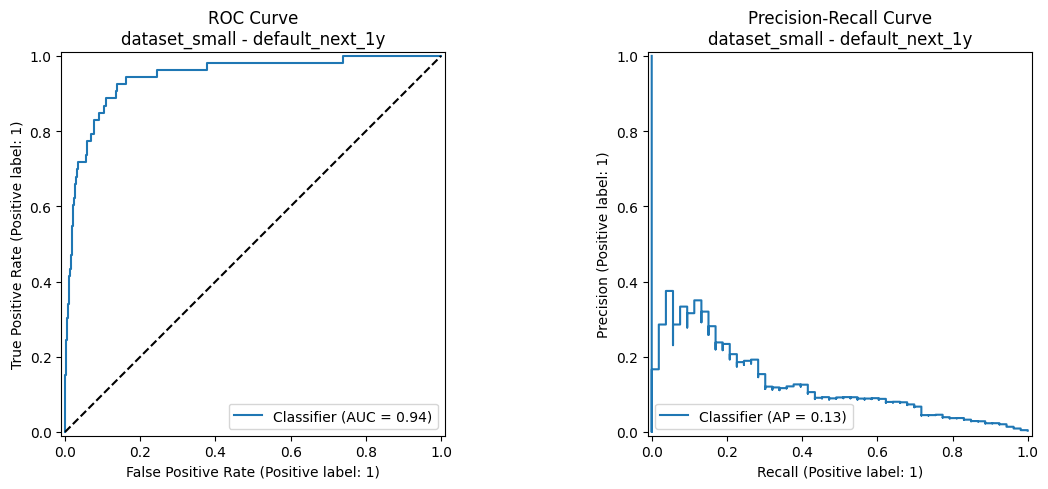


----------------------------------------------------------------------
OUTCOME: default_next_2y
----------------------------------------------------------------------
Class balance: 432 defaults (0.58%) / 74014 non-defaults
Train: 59556 | Test: 14890

>>> Running 5-fold cross-validation...

Cross-Validation Results (5-fold):
  ROC-AUC:   0.909
  Precision: 0.211
  Recall:    0.012
  F1:        0.022

Optimal threshold (F1): 0.07 (score: 0.213)

>>> Fitting final model on full training data...

DATASET: dataset_small | OUTCOME: default_next_2y | THRESHOLD: 0.07

Confusion Matrix:
                 Predicted 0    Predicted 1
  Actual 0           14,700           104
  Actual 1               61            25

Class 1 (Default) Metrics:
  Precision: 0.194
  Recall:    0.291
  F1-Score:  0.233

Overall Metrics:
  Accuracy:  0.989
  ROC-AUC:   0.915
  PR-AUC:    0.136


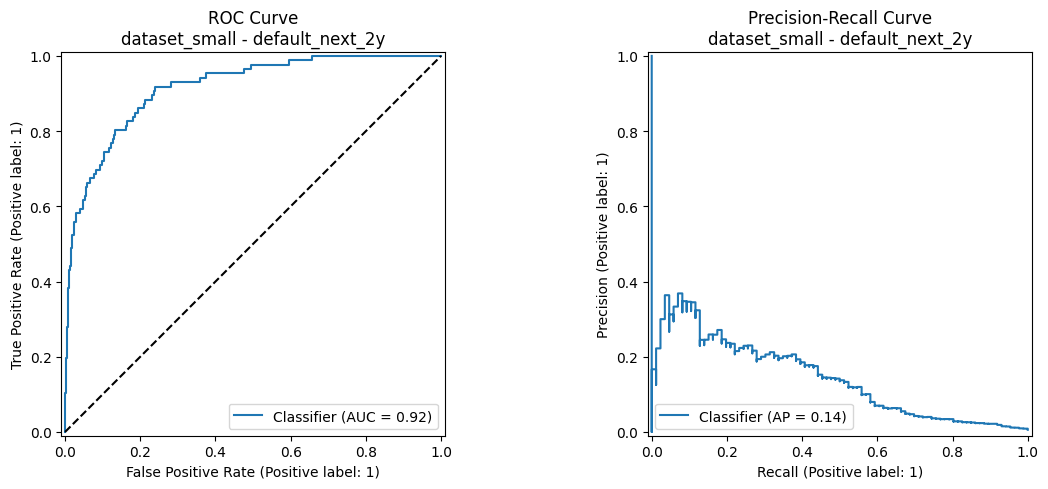


----------------------------------------------------------------------
OUTCOME: default_ever_future
----------------------------------------------------------------------
Class balance: 1438 defaults (1.93%) / 73011 non-defaults
Train: 59559 | Test: 14890

>>> Running 5-fold cross-validation...

Cross-Validation Results (5-fold):
  ROC-AUC:   0.796
  Precision: 0.233
  Recall:    0.009
  F1:        0.017

Optimal threshold (F1): 0.07 (score: 0.174)

>>> Fitting final model on full training data...

DATASET: dataset_small | OUTCOME: default_ever_future | THRESHOLD: 0.07

Confusion Matrix:
                 Predicted 0    Predicted 1
  Actual 0           14,178           424
  Actual 1              191            97

Class 1 (Default) Metrics:
  Precision: 0.186
  Recall:    0.337
  F1-Score:  0.240

Overall Metrics:
  Accuracy:  0.959
  ROC-AUC:   0.820
  PR-AUC:    0.145


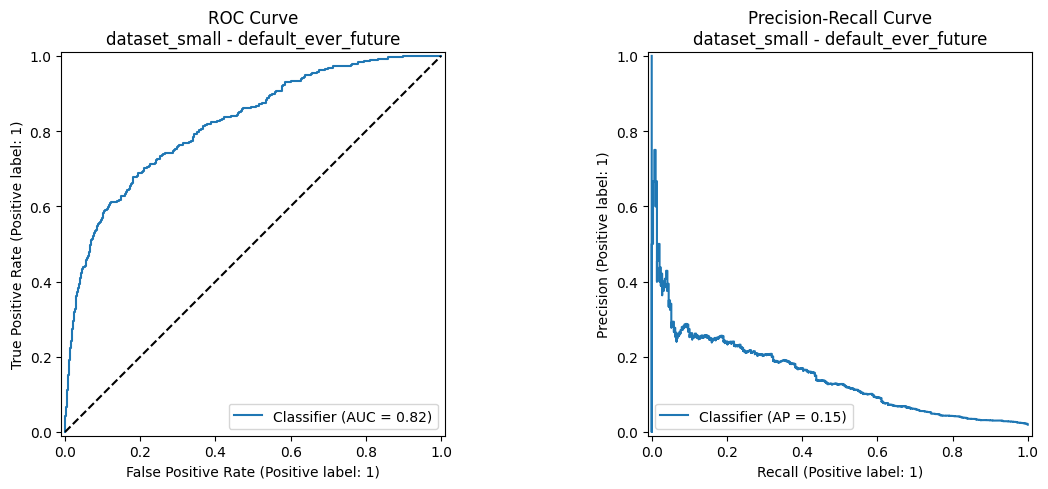


######################################################################
LOADING DATASET: dataset_large
######################################################################
Shape: (107177, 103)
Features: 74
Log-transformed features: 27

----------------------------------------------------------------------
OUTCOME: default_next_1y
----------------------------------------------------------------------
Class balance: 431 defaults (0.44%) / 97427 non-defaults
Train: 78286 | Test: 19572

>>> Running 5-fold cross-validation...

Cross-Validation Results (5-fold):
  ROC-AUC:   0.929
  Precision: 0.294
  Recall:    0.029
  F1:        0.053

Optimal threshold (F1): 0.10 (score: 0.273)

>>> Fitting final model on full training data...

DATASET: dataset_large | OUTCOME: default_next_1y | THRESHOLD: 0.10

Confusion Matrix:
                 Predicted 0    Predicted 1
  Actual 0           19,413            73
  Actual 1               65            21

Class 1 (Default) Metrics:
  Precision: 0.223
 

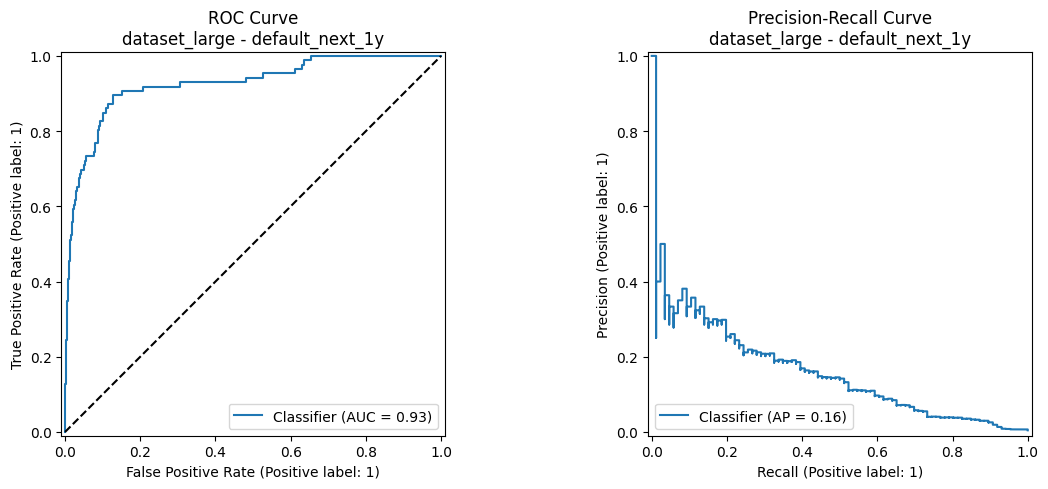


----------------------------------------------------------------------
OUTCOME: default_next_2y
----------------------------------------------------------------------
Class balance: 710 defaults (0.73%) / 97153 non-defaults
Train: 78290 | Test: 19573

>>> Running 5-fold cross-validation...

Cross-Validation Results (5-fold):
  ROC-AUC:   0.903
  Precision: 0.208
  Recall:    0.019
  F1:        0.035

Optimal threshold (F1): 0.10 (score: 0.224)

>>> Fitting final model on full training data...

DATASET: dataset_large | OUTCOME: default_next_2y | THRESHOLD: 0.10

Confusion Matrix:
                 Predicted 0    Predicted 1
  Actual 0           19,290           141
  Actual 1              104            38

Class 1 (Default) Metrics:
  Precision: 0.212
  Recall:    0.268
  F1-Score:  0.237

Overall Metrics:
  Accuracy:  0.987
  ROC-AUC:   0.913
  PR-AUC:    0.122


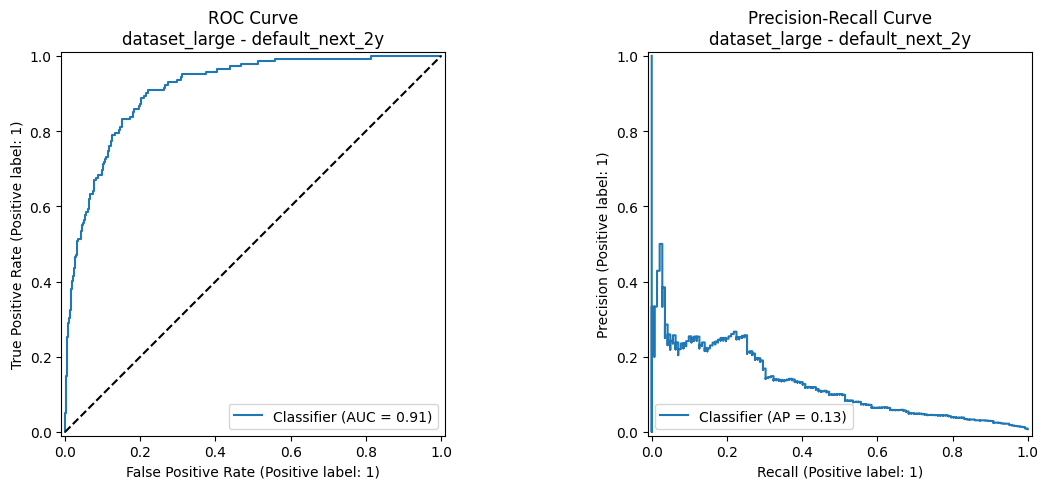


----------------------------------------------------------------------
OUTCOME: default_ever_future
----------------------------------------------------------------------
Class balance: 2390 defaults (2.44%) / 95487 non-defaults
Train: 78301 | Test: 19576

>>> Running 5-fold cross-validation...

Cross-Validation Results (5-fold):
  ROC-AUC:   0.791
  Precision: 0.351
  Recall:    0.014
  F1:        0.026

Optimal threshold (F1): 0.09 (score: 0.203)

>>> Fitting final model on full training data...

DATASET: dataset_large | OUTCOME: default_ever_future | THRESHOLD: 0.09

Confusion Matrix:
                 Predicted 0    Predicted 1
  Actual 0           18,529           569
  Actual 1              378           100

Class 1 (Default) Metrics:
  Precision: 0.149
  Recall:    0.209
  F1-Score:  0.174

Overall Metrics:
  Accuracy:  0.952
  ROC-AUC:   0.789
  PR-AUC:    0.104


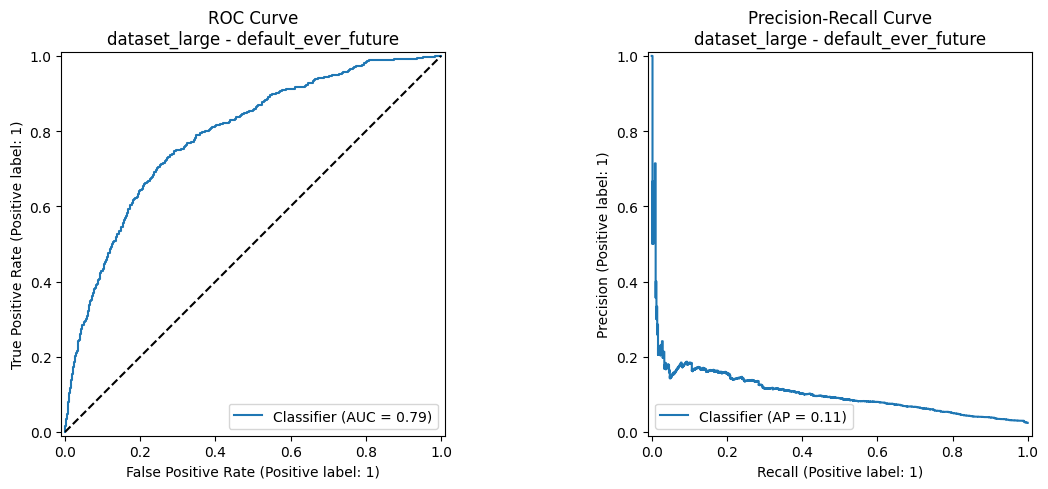

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_predict
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import (
    confusion_matrix, classification_report, roc_auc_score,
    precision_recall_curve, auc, recall_score,
    precision_score, f1_score, RocCurveDisplay, PrecisionRecallDisplay
)
import matplotlib.pyplot as plt


# =============================================================================
# CONFIGURATION
# =============================================================================

DATASETS = {
    'dataset_small': {
        'path': '/Users/adamsujecki/ST310-Predicting-Company-Bankruptcy/notebooks/features_NaN_removed_strong.csv',
        'feature_cols': ['revt', 'oibdp', 'ni', 'xint', 'dp', 'at', 'act', 'che', 'lt', 'lct', 'dlc', 'dltt', 'ceq', 'dv', 
        'cogs','ebit','re','rect','invt','oancf', 'capx', 'fincf', 'ivncf','prcc_f', 'ap', 
        'gross_margin', 'net_profit_margin', 'roa', 'roe', 'asset_turnover','cash_to_assets', 'fixed_asset_intensity', 'current_ratio', 'quick_ratio','total_debt', 'debt_to_assets', 'debt_to_equity', 'liabilities_to_assets','interest_coverage', 'long_term_debt_ratio', 'dividend_payout_ratio', 'dividend_yield', 'retention_ratio','revt_1_year_pct_change', 'at_1_year_pct_change', 'ni_1_year_pct_change','oibdp_1_year_pct_change', 'ceq_1_year_pct_change', 'total_debt_1_year_pct_change','revt_2_year_pct_change', 'at_2_year_pct_change', 'ni_2_year_pct_change','oibdp_2_year_pct_change', 'ceq_2_year_pct_change', 'total_debt_2_year_pct_change', 'revt_5_year_pct_change', 'at_5_year_pct_change', 'ni_5_year_pct_change','oibdp_5_year_pct_change', 'ceq_5_year_pct_change', 'total_debt_5_year_pct_change', 
        'capex_to_assets','investing_cash_flow_to_assets','days_sales_outstanding','days_inventory_outstanding','net_working_capital_to_assets','free_cash_flow_to_sales','financing_cash_flow_to_assets','market_capitalization', 'days_payables_outstanding','cash_conversion_cycle', 
        'capx_1_year_pct_change','market_capitalization_1_year_pct_change','free_cash_flow_to_sales_1_year_pct_change','financing_cash_flow_to_assets_1_year_pct_change', 
        'capx_2_year_pct_change','market_capitalization_2_year_pct_change','free_cash_flow_to_sales_2_year_pct_change','financing_cash_flow_to_assets_2_year_pct_change', 
        'capx_5_year_pct_change','market_capitalization_5_year_pct_change','free_cash_flow_to_sales_5_year_pct_change','financing_cash_flow_to_assets_5_year_pct_change', 
        'cash_conversion_cycle_1_year_pct_change','cash_conversion_cycle_2_year_pct_change','cash_conversion_cycle_5_year_pct_change','book_value_per_share' ],
        'log_cols': ['revt', 'oibdp', 'ni', 'xint', 'dp', 'at', 'act', 'che', 
        'lt', 'lct', 'dlc', 'dltt', 'ceq', 'dv', 
        'cogs','ebit','re','rect','invt','oancf', 
        'capx', 'fincf', 'ivncf','prcc_f', 'ap','total_debt','market_capitalization'] ,  # subset that needs loggin
    },
    'dataset_large': {
        'path': '/Users/adamsujecki/ST310-Predicting-Company-Bankruptcy/notebooks/features_NaN_removed_light.csv',
        'feature_cols': ['revt', 'oibdp', 'ni', 'xint', 'dp', 'at', 'act', 'che', 
        'lt', 'lct', 'dlc', 'dltt', 'ceq', 'dv', 
        'cogs','ebit','re','rect','invt','oancf', 'capx', 'fincf', 'ivncf','prcc_f', 'ap', 
        'gross_margin', 'net_profit_margin', 'roa', 'roe', 'asset_turnover','cash_to_assets', 'fixed_asset_intensity', 'current_ratio', 'quick_ratio','total_debt', 'debt_to_assets', 'debt_to_equity', 'liabilities_to_assets','interest_coverage', 'long_term_debt_ratio', 'dividend_payout_ratio', 'dividend_yield', 'retention_ratio','revt_1_year_pct_change', 'at_1_year_pct_change', 'ni_1_year_pct_change','oibdp_1_year_pct_change', 'ceq_1_year_pct_change', 'total_debt_1_year_pct_change','revt_2_year_pct_change', 'at_2_year_pct_change', 'ni_2_year_pct_change','oibdp_2_year_pct_change', 'ceq_2_year_pct_change', 'total_debt_2_year_pct_change', 'revt_5_year_pct_change', 'at_5_year_pct_change', 'ni_5_year_pct_change','oibdp_5_year_pct_change', 'ceq_5_year_pct_change', 'total_debt_5_year_pct_change', 
        'capex_to_assets','investing_cash_flow_to_assets','days_sales_outstanding','days_inventory_outstanding','net_working_capital_to_assets','free_cash_flow_to_sales','financing_cash_flow_to_assets','market_capitalization', 'days_payables_outstanding','cash_conversion_cycle','market_capitalization_1_year_pct_change', 
        'market_capitalization_2_year_pct_change','book_value_per_share'] ,
        'log_cols': ['revt', 'oibdp', 'ni', 'xint', 'dp', 'at', 'act', 'che', 
        'lt', 'lct', 'dlc', 'dltt', 'ceq', 'dv', 
        'cogs','ebit','re','rect','invt','oancf', 
        'capx', 'fincf', 'ivncf','prcc_f', 'ap','total_debt','market_capitalization'] ,  # subset that needs loggin
    },
}

OUTCOME_COLS = ['default_next_1y','default_next_2y','default_ever_future']  # replace with actual


TEST_SIZE = 0.2
RANDOM_STATE = 42
CV_FOLDS = 5


# =============================================================================
# PREPROCESSING FUNCTIONS
# =============================================================================

def signed_log1p(x):
    """
    Signed log transform that handles negative, zero, and positive values.
    Returns: sign(x) * log(1 + |x|)
    """
    return np.sign(x) * np.log1p(np.abs(x))


def create_preprocessor(feature_cols, log_cols):
    """
    Creates a column transformer that:
    1. Applies signed log transform to specified columns, then standardizes
    2. Standardizes remaining columns directly
    """
    non_log_cols = [c for c in feature_cols if c not in log_cols]
    
    transformers = []
    
    if log_cols:
        transformers.append((
            'log_features',
            Pipeline([
                ('log', FunctionTransformer(signed_log1p, validate=True)),
                ('scale', StandardScaler())
            ]),
            log_cols
        ))
    
    if non_log_cols:
        transformers.append((
            'standard_features',
            StandardScaler(),
            non_log_cols
        ))
    
    return ColumnTransformer(transformers, remainder='drop')


# =============================================================================
# MODEL PIPELINE
# =============================================================================

def create_svm_pipeline(preprocessor):
    """
    Creates full pipeline: preprocessing -> LinearSVC with calibration
    """
    return Pipeline([
        ('preprocessor', preprocessor),
        ('svm', CalibratedClassifierCV(
            LinearSVC(
                class_weight='balanced',
                max_iter=100000,
                dual='auto',
                random_state=RANDOM_STATE
            ),
            cv=3,
            method='sigmoid'
        ))
    ])


# =============================================================================
# THRESHOLD OPTIMIZATION
# =============================================================================

def find_optimal_threshold(y_true, y_prob, optimize_for='f1'):
    """
    Finds optimal threshold from pre-computed probabilities.
    No refitting required.
    """
    best_threshold = 0.5
    best_score = 0
    
    for thresh in np.arange(0.05, 0.95, 0.01):
        y_pred = (y_prob >= thresh).astype(int)
        
        if optimize_for == 'f1':
            score = f1_score(y_true, y_pred, zero_division=0)
        elif optimize_for == 'recall':
            score = recall_score(y_true, y_pred, zero_division=0)
        elif optimize_for == 'precision':
            score = precision_score(y_true, y_pred, zero_division=0)
        
        if score > best_score:
            best_score = score
            best_threshold = thresh
    
    return best_threshold, best_score


# =============================================================================
# EVALUATION FUNCTIONS
# =============================================================================

def evaluate_model(pipeline, X_test, y_test, threshold=0.5):
    """
    Evaluates already-fitted pipeline on test set.
    """
    y_prob = pipeline.predict_proba(X_test)[:, 1]
    y_pred = (y_prob >= threshold).astype(int)
    
    results = {
        'confusion_matrix': confusion_matrix(y_test, y_pred),
        'classification_report': classification_report(y_test, y_pred, output_dict=True),
        'roc_auc': roc_auc_score(y_test, y_prob),
        'y_prob': y_prob,
        'y_pred': y_pred,
        'y_test': y_test,
    }
    
    precision_vals, recall_vals, _ = precision_recall_curve(y_test, y_prob)
    results['pr_auc'] = auc(recall_vals, precision_vals)
    
    return results


def print_evaluation(results, dataset_name, outcome_col, threshold):
    """
    Prints formatted evaluation results.
    """
    print("\n" + "=" * 70)
    print(f"DATASET: {dataset_name} | OUTCOME: {outcome_col} | THRESHOLD: {threshold:.2f}")
    print("=" * 70)
    
    cm = results['confusion_matrix']
    print(f"\nConfusion Matrix:")
    print(f"                 Predicted 0    Predicted 1")
    print(f"  Actual 0       {cm[0,0]:>10,}    {cm[0,1]:>10,}")
    print(f"  Actual 1       {cm[1,0]:>10,}    {cm[1,1]:>10,}")
    
    report = results['classification_report']
    print(f"\nClass 1 (Default) Metrics:")
    print(f"  Precision: {report['1']['precision']:.3f}")
    print(f"  Recall:    {report['1']['recall']:.3f}")
    print(f"  F1-Score:  {report['1']['f1-score']:.3f}")
    
    print(f"\nOverall Metrics:")
    print(f"  Accuracy:  {report['accuracy']:.3f}")
    print(f"  ROC-AUC:   {results['roc_auc']:.3f}")
    print(f"  PR-AUC:    {results['pr_auc']:.3f}")


def plot_curves(results, dataset_name, outcome_col):
    """
    Plots ROC and Precision-Recall curves.
    """
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    RocCurveDisplay.from_predictions(
        results['y_test'], results['y_prob'], ax=axes[0]
    )
    axes[0].set_title(f'ROC Curve\n{dataset_name} - {outcome_col}')
    axes[0].plot([0, 1], [0, 1], 'k--', label='Random')
    
    PrecisionRecallDisplay.from_predictions(
        results['y_test'], results['y_prob'], ax=axes[1]
    )
    axes[1].set_title(f'Precision-Recall Curve\n{dataset_name} - {outcome_col}')
    
    plt.tight_layout()
    plt.show()


def print_cv_results(cv_scores):
    """
    Prints cross-validation results.
    """
    print(f"\nCross-Validation Results ({CV_FOLDS}-fold):")
    
    # Calculate metrics from out-of-fold predictions
    y_true = cv_scores['y_true']
    y_prob = cv_scores['y_prob']
    y_pred = (y_prob >= 0.5).astype(int)
    
    print(f"  ROC-AUC:   {roc_auc_score(y_true, y_prob):.3f}")
    print(f"  Precision: {precision_score(y_true, y_pred, zero_division=0):.3f}")
    print(f"  Recall:    {recall_score(y_true, y_pred, zero_division=0):.3f}")
    print(f"  F1:        {f1_score(y_true, y_pred, zero_division=0):.3f}")


# =============================================================================
# MAIN EXECUTION
# =============================================================================

def run_full_analysis(datasets=DATASETS, outcomes=OUTCOME_COLS):
    """
    Runs the complete analysis across all configurations.
    
    Optimized flow:
    1. Cross-validation to get out-of-fold predictions
    2. Find optimal threshold using those predictions (no refitting)
    3. Fit once on full training data
    4. Evaluate on test set
    """
    all_results = {}
    
    for dataset_name, config in datasets.items():
        print(f"\n{'#' * 70}")
        print(f"LOADING DATASET: {dataset_name}")
        print(f"{'#' * 70}")
        
        df = pd.read_csv(config['path'])
        feature_cols = config['feature_cols']
        log_cols = config['log_cols']
        
        print(f"Shape: {df.shape}")
        print(f"Features: {len(feature_cols)}")
        print(f"Log-transformed features: {len(log_cols)}")
        
        for outcome_col in outcomes:
            print(f"\n{'-' * 70}")
            print(f"OUTCOME: {outcome_col}")
            print(f"{'-' * 70}")
            
            # Drop rows with NaN in outcome
            df_clean = df.dropna(subset=[outcome_col])
            X = df_clean[feature_cols].copy()
            y = df_clean[outcome_col].astype(int)
            
            # Report class balance
            n_defaults = y.sum()
            n_total = len(y)
            print(f"Class balance: {n_defaults} defaults ({n_defaults/n_total*100:.2f}%) / {n_total - n_defaults} non-defaults")
            
            # Stratified train/test split
            X_train, X_test, y_train, y_test = train_test_split(
                X, y,
                test_size=TEST_SIZE,
                stratify=y,
                random_state=RANDOM_STATE
            )
            
            print(f"Train: {len(X_train)} | Test: {len(X_test)}")
            
            # Create pipeline
            preprocessor = create_preprocessor(feature_cols, log_cols)
            pipeline = create_svm_pipeline(preprocessor)
            
            # -----------------------------------------------------------------
            # Step 1: Cross-validation to get out-of-fold predictions
            # -----------------------------------------------------------------
            print(f"\n>>> Running {CV_FOLDS}-fold cross-validation...")
            
            cv = StratifiedKFold(n_splits=CV_FOLDS, shuffle=True, random_state=RANDOM_STATE)
            
            # Get out-of-fold probability predictions
            y_prob_oof = cross_val_predict(
                pipeline, X_train, y_train,
                cv=cv,
                method='predict_proba',
                n_jobs=-1
            )[:, 1]
            
            cv_scores = {
                'y_true': y_train.values,
                'y_prob': y_prob_oof
            }
            
            print_cv_results(cv_scores)
            
            # -----------------------------------------------------------------
            # Step 2: Find optimal threshold using out-of-fold predictions
            # -----------------------------------------------------------------
            optimal_thresh, thresh_score = find_optimal_threshold(
                y_train.values, y_prob_oof, optimize_for='f1'
            )
            print(f"\nOptimal threshold (F1): {optimal_thresh:.2f} (score: {thresh_score:.3f})")
            
            # -----------------------------------------------------------------
            # Step 3: Fit once on full training data
            # -----------------------------------------------------------------
            print(f"\n>>> Fitting final model on full training data...")
            pipeline.fit(X_train, y_train)
            
            # -----------------------------------------------------------------
            # Step 4: Evaluate on test set
            # -----------------------------------------------------------------
            results = evaluate_model(pipeline, X_test, y_test, threshold=optimal_thresh)
            
            print_evaluation(results, dataset_name, outcome_col, optimal_thresh)
            plot_curves(results, dataset_name, outcome_col)
            
            # Store results
            key = (dataset_name, outcome_col)
            all_results[key] = {
                'cv_scores': cv_scores,
                'test_results': results,
                'optimal_threshold': optimal_thresh,
                'pipeline': pipeline
            }
    
    return all_results


# =============================================================================
# RUN
# =============================================================================

if __name__ == "__main__":
    results = run_full_analysis()

In [3]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_predict
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.metrics import (
    confusion_matrix, classification_report, roc_auc_score,
    precision_recall_curve, auc, recall_score,
    precision_score, f1_score, RocCurveDisplay, PrecisionRecallDisplay
)
import matplotlib.pyplot as plt


# =============================================================================
# CONFIGURATION
# =============================================================================

DATASETS = {
    'dataset_small': {
        'path': '/Users/adamsujecki/ST310-Predicting-Company-Bankruptcy/notebooks/features_NaN_removed_strong.csv',
        'feature_cols': ['revt', 'oibdp', 'ni', 'xint', 'dp', 'at', 'act', 'che', 'lt', 'lct', 'dlc', 'dltt', 'ceq', 'dv', 
        'cogs','ebit','re','rect','invt','oancf', 'capx', 'fincf', 'ivncf','prcc_f', 'ap', 
        'gross_margin', 'net_profit_margin', 'roa', 'roe', 'asset_turnover','cash_to_assets', 'fixed_asset_intensity', 'current_ratio', 'quick_ratio','total_debt', 'debt_to_assets', 'debt_to_equity', 'liabilities_to_assets','interest_coverage', 'long_term_debt_ratio', 'dividend_payout_ratio', 'dividend_yield', 'retention_ratio','revt_1_year_pct_change', 'at_1_year_pct_change', 'ni_1_year_pct_change','oibdp_1_year_pct_change', 'ceq_1_year_pct_change', 'total_debt_1_year_pct_change','revt_2_year_pct_change', 'at_2_year_pct_change', 'ni_2_year_pct_change','oibdp_2_year_pct_change', 'ceq_2_year_pct_change', 'total_debt_2_year_pct_change', 'revt_5_year_pct_change', 'at_5_year_pct_change', 'ni_5_year_pct_change','oibdp_5_year_pct_change', 'ceq_5_year_pct_change', 'total_debt_5_year_pct_change', 
        'capex_to_assets','investing_cash_flow_to_assets','days_sales_outstanding','days_inventory_outstanding','net_working_capital_to_assets','free_cash_flow_to_sales','financing_cash_flow_to_assets','market_capitalization', 'days_payables_outstanding','cash_conversion_cycle', 
        'capx_1_year_pct_change','market_capitalization_1_year_pct_change','free_cash_flow_to_sales_1_year_pct_change','financing_cash_flow_to_assets_1_year_pct_change', 
        'capx_2_year_pct_change','market_capitalization_2_year_pct_change','free_cash_flow_to_sales_2_year_pct_change','financing_cash_flow_to_assets_2_year_pct_change', 
        'capx_5_year_pct_change','market_capitalization_5_year_pct_change','free_cash_flow_to_sales_5_year_pct_change','financing_cash_flow_to_assets_5_year_pct_change', 
        'cash_conversion_cycle_1_year_pct_change','cash_conversion_cycle_2_year_pct_change','cash_conversion_cycle_5_year_pct_change','book_value_per_share' ],
        'log_cols': ['revt', 'oibdp', 'ni', 'xint', 'dp', 'at', 'act', 'che', 
        'lt', 'lct', 'dlc', 'dltt', 'ceq', 'dv', 
        'cogs','ebit','re','rect','invt','oancf', 
        'capx', 'fincf', 'ivncf','prcc_f', 'ap','total_debt','market_capitalization'] ,  # subset that needs loggin
    },
    'dataset_large': {
        'path': '/Users/adamsujecki/ST310-Predicting-Company-Bankruptcy/notebooks/features_NaN_removed_light.csv',
        'feature_cols': ['revt', 'oibdp', 'ni', 'xint', 'dp', 'at', 'act', 'che', 
        'lt', 'lct', 'dlc', 'dltt', 'ceq', 'dv', 
        'cogs','ebit','re','rect','invt','oancf', 'capx', 'fincf', 'ivncf','prcc_f', 'ap', 
        'gross_margin', 'net_profit_margin', 'roa', 'roe', 'asset_turnover','cash_to_assets', 'fixed_asset_intensity', 'current_ratio', 'quick_ratio','total_debt', 'debt_to_assets', 'debt_to_equity', 'liabilities_to_assets','interest_coverage', 'long_term_debt_ratio', 'dividend_payout_ratio', 'dividend_yield', 'retention_ratio','revt_1_year_pct_change', 'at_1_year_pct_change', 'ni_1_year_pct_change','oibdp_1_year_pct_change', 'ceq_1_year_pct_change', 'total_debt_1_year_pct_change','revt_2_year_pct_change', 'at_2_year_pct_change', 'ni_2_year_pct_change','oibdp_2_year_pct_change', 'ceq_2_year_pct_change', 'total_debt_2_year_pct_change', 'revt_5_year_pct_change', 'at_5_year_pct_change', 'ni_5_year_pct_change','oibdp_5_year_pct_change', 'ceq_5_year_pct_change', 'total_debt_5_year_pct_change', 
        'capex_to_assets','investing_cash_flow_to_assets','days_sales_outstanding','days_inventory_outstanding','net_working_capital_to_assets','free_cash_flow_to_sales','financing_cash_flow_to_assets','market_capitalization', 'days_payables_outstanding','cash_conversion_cycle','market_capitalization_1_year_pct_change', 
        'market_capitalization_2_year_pct_change','book_value_per_share'] ,
        'log_cols': ['revt', 'oibdp', 'ni', 'xint', 'dp', 'at', 'act', 'che', 
        'lt', 'lct', 'dlc', 'dltt', 'ceq', 'dv', 
        'cogs','ebit','re','rect','invt','oancf', 
        'capx', 'fincf', 'ivncf','prcc_f', 'ap','total_debt','market_capitalization'] ,  # subset that needs loggin
    },
}

OUTCOME_COLS = ['default_next_1y','default_next_2y']  # replace with actual



TEST_SIZE = 0.2
RANDOM_STATE = 42
CV_FOLDS = 5


# =============================================================================
# PREPROCESSING FUNCTIONS
# =============================================================================

def signed_log1p(x):
    """
    Signed log transform that handles negative, zero, and positive values.
    Returns: sign(x) * log(1 + |x|)
    """
    return np.sign(x) * np.log1p(np.abs(x))


def create_preprocessor(feature_cols, log_cols):
    """
    Creates a column transformer that:
    1. Applies signed log transform to specified columns, then standardizes
    2. Standardizes remaining columns directly
    """
    non_log_cols = [c for c in feature_cols if c not in log_cols]
    
    transformers = []
    
    if log_cols:
        transformers.append((
            'log_features',
            Pipeline([
                ('log', FunctionTransformer(signed_log1p, validate=True)),
                ('scale', StandardScaler())
            ]),
            log_cols
        ))
    
    if non_log_cols:
        transformers.append((
            'standard_features',
            StandardScaler(),
            non_log_cols
        ))
    
    return ColumnTransformer(transformers, remainder='drop')


# =============================================================================
# MODEL PIPELINE
# =============================================================================

def create_svm_pipeline(preprocessor, kernel='linear'):
    """
    Creates full pipeline: preprocessing -> SVC
    """
    return Pipeline([
        ('preprocessor', preprocessor),
        ('svm', SVC(
            kernel=kernel,
            class_weight='balanced',
            probability=True,
            random_state=RANDOM_STATE
        ))
    ])


# =============================================================================
# THRESHOLD OPTIMIZATION
# =============================================================================

def find_optimal_threshold(y_true, y_prob, optimize_for='f1'):
    """
    Finds optimal threshold from pre-computed probabilities.
    No refitting required.
    """
    best_threshold = 0.5
    best_score = 0
    
    for thresh in np.arange(0.05, 0.95, 0.01):
        y_pred = (y_prob >= thresh).astype(int)
        
        if optimize_for == 'f1':
            score = f1_score(y_true, y_pred, zero_division=0)
        elif optimize_for == 'recall':
            score = recall_score(y_true, y_pred, zero_division=0)
        elif optimize_for == 'precision':
            score = precision_score(y_true, y_pred, zero_division=0)
        
        if score > best_score:
            best_score = score
            best_threshold = thresh
    
    return best_threshold, best_score


# =============================================================================
# EVALUATION FUNCTIONS
# =============================================================================

def evaluate_model(pipeline, X_test, y_test, threshold=0.5):
    """
    Evaluates already-fitted pipeline on test set.
    """
    y_prob = pipeline.predict_proba(X_test)[:, 1]
    y_pred = (y_prob >= threshold).astype(int)
    
    results = {
        'confusion_matrix': confusion_matrix(y_test, y_pred),
        'classification_report': classification_report(y_test, y_pred, output_dict=True),
        'roc_auc': roc_auc_score(y_test, y_prob),
        'y_prob': y_prob,
        'y_pred': y_pred,
        'y_test': y_test,
    }
    
    precision_vals, recall_vals, _ = precision_recall_curve(y_test, y_prob)
    results['pr_auc'] = auc(recall_vals, precision_vals)
    
    return results


def print_evaluation(results, dataset_name, outcome_col, kernel, threshold):
    """
    Prints formatted evaluation results.
    """
    print("\n" + "=" * 70)
    print(f"DATASET: {dataset_name} | OUTCOME: {outcome_col} | KERNEL: {kernel} | THRESHOLD: {threshold:.2f}")
    print("=" * 70)
    
    cm = results['confusion_matrix']
    print(f"\nConfusion Matrix:")
    print(f"                 Predicted 0    Predicted 1")
    print(f"  Actual 0       {cm[0,0]:>10,}    {cm[0,1]:>10,}")
    print(f"  Actual 1       {cm[1,0]:>10,}    {cm[1,1]:>10,}")
    
    report = results['classification_report']
    print(f"\nClass 1 (Default) Metrics:")
    print(f"  Precision: {report['1']['precision']:.3f}")
    print(f"  Recall:    {report['1']['recall']:.3f}")
    print(f"  F1-Score:  {report['1']['f1-score']:.3f}")
    
    print(f"\nOverall Metrics:")
    print(f"  Accuracy:  {report['accuracy']:.3f}")
    print(f"  ROC-AUC:   {results['roc_auc']:.3f}")
    print(f"  PR-AUC:    {results['pr_auc']:.3f}")


def plot_curves(results, dataset_name, outcome_col, kernel):
    """
    Plots ROC and Precision-Recall curves.
    """
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    RocCurveDisplay.from_predictions(
        results['y_test'], results['y_prob'], ax=axes[0]
    )
    axes[0].set_title(f'ROC Curve\n{dataset_name} - {outcome_col} - {kernel}')
    axes[0].plot([0, 1], [0, 1], 'k--', label='Random')
    
    PrecisionRecallDisplay.from_predictions(
        results['y_test'], results['y_prob'], ax=axes[1]
    )
    axes[1].set_title(f'Precision-Recall Curve\n{dataset_name} - {outcome_col} - {kernel}')
    
    plt.tight_layout()
    plt.show()


def print_cv_results(cv_scores):
    """
    Prints cross-validation results.
    """
    print(f"\nCross-Validation Results ({CV_FOLDS}-fold):")
    
    y_true = cv_scores['y_true']
    y_prob = cv_scores['y_prob']
    y_pred = (y_prob >= 0.5).astype(int)
    
    print(f"  ROC-AUC:   {roc_auc_score(y_true, y_prob):.3f}")
    print(f"  Precision: {precision_score(y_true, y_pred, zero_division=0):.3f}")
    print(f"  Recall:    {recall_score(y_true, y_pred, zero_division=0):.3f}")
    print(f"  F1:        {f1_score(y_true, y_pred, zero_division=0):.3f}")


# =============================================================================
# MAIN EXECUTION
# =============================================================================

def run_full_analysis(datasets=DATASETS, outcomes=OUTCOME_COLS, kernels=['linear']):
    """
    Runs the complete analysis across all configurations.
    
    Optimized flow:
    1. Cross-validation to get out-of-fold predictions
    2. Find optimal threshold using those predictions (no refitting)
    3. Fit once on full training data
    4. Evaluate on test set
    """
    all_results = {}
    
    for dataset_name, config in datasets.items():
        print(f"\n{'#' * 70}")
        print(f"LOADING DATASET: {dataset_name}")
        print(f"{'#' * 70}")
        
        df = pd.read_csv(config['path'])
        feature_cols = config['feature_cols']
        log_cols = config['log_cols']
        
        print(f"Shape: {df.shape}")
        print(f"Features: {len(feature_cols)}")
        print(f"Log-transformed features: {len(log_cols)}")
        
        for outcome_col in outcomes:
            print(f"\n{'-' * 70}")
            print(f"OUTCOME: {outcome_col}")
            print(f"{'-' * 70}")
            
            # Drop rows with NaN in outcome
            df_clean = df.dropna(subset=[outcome_col])
            X = df_clean[feature_cols].copy()
            y = df_clean[outcome_col].astype(int)
            
            # Report class balance
            n_defaults = y.sum()
            n_total = len(y)
            print(f"Class balance: {n_defaults} defaults ({n_defaults/n_total*100:.2f}%) / {n_total - n_defaults} non-defaults")
            
            # Stratified train/test split
            X_train, X_test, y_train, y_test = train_test_split(
                X, y,
                test_size=TEST_SIZE,
                stratify=y,
                random_state=RANDOM_STATE
            )
            
            print(f"Train: {len(X_train)} | Test: {len(X_test)}")
            
            for kernel in kernels:
                print(f"\n>>> Kernel: {kernel.upper()}")
                
                # Create pipeline
                preprocessor = create_preprocessor(feature_cols, log_cols)
                pipeline = create_svm_pipeline(preprocessor, kernel=kernel)
                
                # -------------------------------------------------------------
                # Step 1: Cross-validation to get out-of-fold predictions
                # -------------------------------------------------------------
                print(f"Running {CV_FOLDS}-fold cross-validation...")
                
                cv = StratifiedKFold(n_splits=CV_FOLDS, shuffle=True, random_state=RANDOM_STATE)
                
                y_prob_oof = cross_val_predict(
                    pipeline, X_train, y_train,
                    cv=cv,
                    method='predict_proba',
                    n_jobs=-1
                )[:, 1]
                
                cv_scores = {
                    'y_true': y_train.values,
                    'y_prob': y_prob_oof
                }
                
                print_cv_results(cv_scores)
                
                # -------------------------------------------------------------
                # Step 2: Find optimal threshold using out-of-fold predictions
                # -------------------------------------------------------------
                optimal_thresh, thresh_score = find_optimal_threshold(
                    y_train.values, y_prob_oof, optimize_for='f1'
                )
                print(f"\nOptimal threshold (F1): {optimal_thresh:.2f} (score: {thresh_score:.3f})")
                
                # -------------------------------------------------------------
                # Step 3: Fit once on full training data
                # -------------------------------------------------------------
                print(f"Fitting final model on full training data...")
                pipeline.fit(X_train, y_train)
                
                # -------------------------------------------------------------
                # Step 4: Evaluate on test set
                # -------------------------------------------------------------
                results = evaluate_model(pipeline, X_test, y_test, threshold=optimal_thresh)
                
                print_evaluation(results, dataset_name, outcome_col, kernel, optimal_thresh)
                plot_curves(results, dataset_name, outcome_col, kernel)
                
                # Store results
                key = (dataset_name, outcome_col, kernel)
                all_results[key] = {
                    'cv_scores': cv_scores,
                    'test_results': results,
                    'optimal_threshold': optimal_thresh,
                    'pipeline': pipeline
                }
    
    return all_results


# =============================================================================
# RUN
# =============================================================================

#if __name__ == "__main__":
    # Default: linear only (faster)
    # For comparison with LinearSVC, run with just linear
    #results = run_full_analysis(kernels=['rbf'])
    
    # To also test RBF (much slower):
    # results = run_full_analysis(kernels=['linear', 'rbf'])


######################################################################
LOADING DATASET: dataset_small
######################################################################
Shape: (81750, 103)
Features: 87
Log-transformed features: 27

----------------------------------------------------------------------
OUTCOME: default_next_1y
----------------------------------------------------------------------
Class balance: 267 defaults (0.36%) / 74176 non-defaults
Train: 59554 | Test: 14889

>>> Kernel: LINEAR
Running 5-fold cross-validation...

Cross-Validation Results (5-fold):
  ROC-AUC:   0.903
  Precision: 0.071
  Recall:    0.005
  F1:        0.009

Optimal threshold (F1): 0.05 (score: 0.213)
Fitting final model on full training data...

DATASET: dataset_small | OUTCOME: default_next_1y | KERNEL: linear | THRESHOLD: 0.05

Confusion Matrix:
                 Predicted 0    Predicted 1
  Actual 0           14,778            58
  Actual 1               42            11

Class 1 (Default) Met

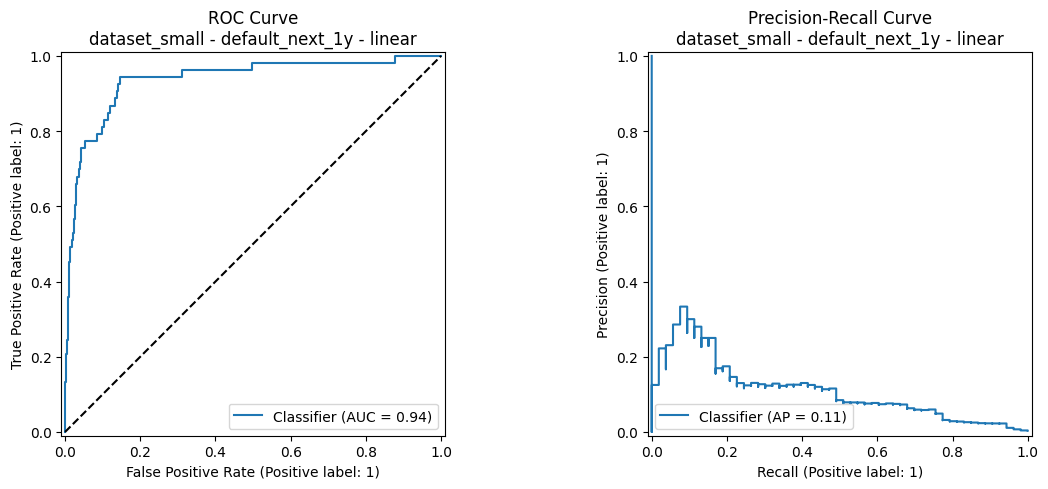


----------------------------------------------------------------------
OUTCOME: default_next_2y
----------------------------------------------------------------------
Class balance: 432 defaults (0.58%) / 74014 non-defaults
Train: 59556 | Test: 14890

>>> Kernel: LINEAR
Running 5-fold cross-validation...

Cross-Validation Results (5-fold):
  ROC-AUC:   0.896
  Precision: 0.120
  Recall:    0.009
  F1:        0.016

Optimal threshold (F1): 0.08 (score: 0.179)
Fitting final model on full training data...

DATASET: dataset_small | OUTCOME: default_next_2y | KERNEL: linear | THRESHOLD: 0.08

Confusion Matrix:
                 Predicted 0    Predicted 1
  Actual 0           14,753            51
  Actual 1               71            15

Class 1 (Default) Metrics:
  Precision: 0.227
  Recall:    0.174
  F1-Score:  0.197

Overall Metrics:
  Accuracy:  0.992
  ROC-AUC:   0.910
  PR-AUC:    0.113


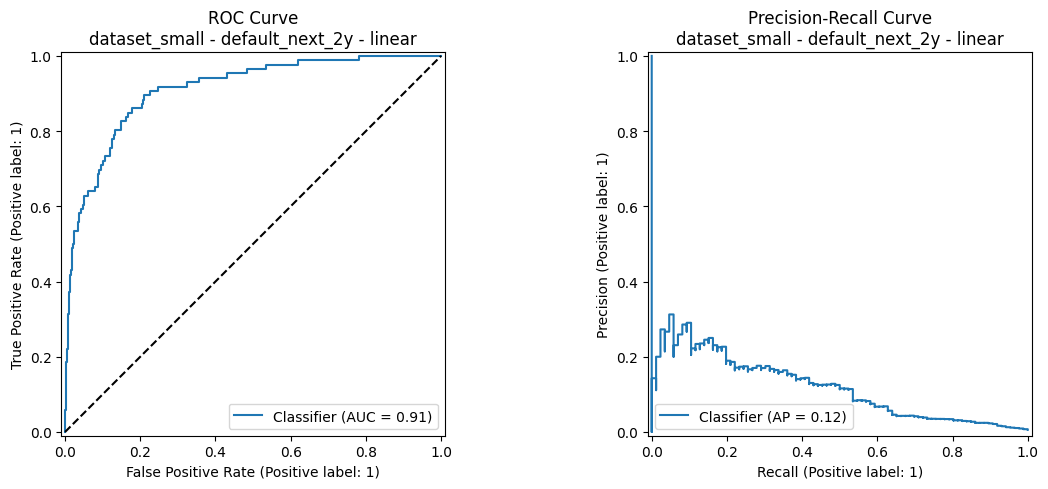


######################################################################
LOADING DATASET: dataset_large
######################################################################
Shape: (107177, 103)
Features: 74
Log-transformed features: 27

----------------------------------------------------------------------
OUTCOME: default_next_1y
----------------------------------------------------------------------
Class balance: 431 defaults (0.44%) / 97427 non-defaults
Train: 78286 | Test: 19572

>>> Kernel: LINEAR
Running 5-fold cross-validation...

Cross-Validation Results (5-fold):
  ROC-AUC:   0.928
  Precision: 0.267
  Recall:    0.023
  F1:        0.043

Optimal threshold (F1): 0.08 (score: 0.259)
Fitting final model on full training data...

DATASET: dataset_large | OUTCOME: default_next_1y | KERNEL: linear | THRESHOLD: 0.08

Confusion Matrix:
                 Predicted 0    Predicted 1
  Actual 0           19,403            83
  Actual 1               62            24

Class 1 (Default) Me

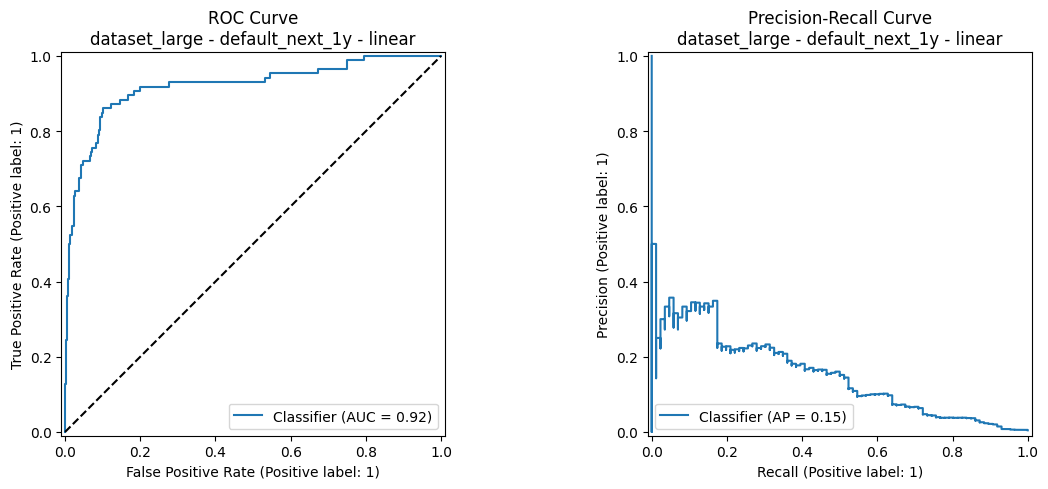


----------------------------------------------------------------------
OUTCOME: default_next_2y
----------------------------------------------------------------------
Class balance: 710 defaults (0.73%) / 97153 non-defaults
Train: 78290 | Test: 19573

>>> Kernel: LINEAR
Running 5-fold cross-validation...


In [ ]:
results = run_full_analysis(kernels=['linear'])